In [1]:
#Load-in required packages and data
import os
os.chdir("E:/Projects/prediction")
import numpy as np
import pandas as pd
import random
import pycaret
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
data_city = pd.read_csv("data_city.txt",sep = "\t")
data_city = data_city.drop(axis = 1,columns = ['SampleID'])

In [2]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score, recall_score

def stat_table(y_true,y_pred,pos_label):
    Accu = accuracy_score(y_true, y_pred)
    Recall = recall_score(y_true, y_pred, pos_label = pos_label)
    Prec = precision_score(y_true, y_pred, pos_label = pos_label)
    result = pd.DataFrame({'Accuracy':[Accu],'Recall':[Recall],'Precision':[Prec]})
    return result

def acu_curve(y_test,prob,classes,sites):
    y = label_binarize(y_test, classes=classes)
    y = np.hstack((1-y,y))
    fpr,tpr,threshold = roc_curve(y.ravel(),prob.ravel()) ###计算真正率和假正率
    a = np.transpose([tpr,fpr])
    ap = pd.DataFrame(a)
    ap.columns = ['TPR','FPR']
    ap.to_csv(sites[0]+'_'+sites[1]+'_'+classes[1]+'.csv',index=False)
    
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='lightcoral',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='mediumaquamarine', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(sites[0]+'_'+sites[1]+'_'+classes[1]+'.pdf')
 
    plt.show()

In [3]:
data_city['FEV1_rate'] = 1/data_city['FEV1_rate']
data_A = data_city[data_city['Site']=='Southampton']
data_B = data_city[data_city['Site']=='Manchester']
data_C = data_city[data_city['Site']=='Leicester']
site_AB = ['Southampton','Manchester']
site_AC = ['Southampton','Leicester']
site_BC = ['Manchester','Leicester']

## Site A & B for fitting, C for prediction

In [4]:
from pycaret.regression import *
data_AB = pd.concat([data_A,data_B])
setup(data_AB, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7, train_size = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group','Site'],silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,322.3682,383191.6360,490.5168,-0.1632,1.5692,1.0081,0.0540
br,Bayesian Ridge,326.6323,376738.5816,494.8121,-0.2447,1.0835,1.4262,0.0120
knn,K Neighbors Regressor,342.2812,390619.2855,508.0753,-0.5164,1.5492,1.5594,0.0100
et,Extra Trees Regressor,369.1178,410499.7502,531.2685,-1.0142,1.6139,1.9391,0.1270
gbr,Gradient Boosting Regressor,397.9136,469151.0496,564.0680,-1.0193,1.4562,2.1186,0.0510
en,Elastic Net,445.0398,463045.9781,598.9087,-1.5393,1.5622,2.9154,0.0090
lightgbm,Light Gradient Boosting Machine,435.9224,488729.3189,610.3296,-1.6526,1.5328,2.6466,0.1600
rf,Random Forest Regressor,410.1357,484081.2833,591.7305,-2.1717,1.6500,2.1541,0.1730
xgboost,Extreme Gradient Boosting,442.3101,677738.4621,675.1255,-3.1093,1.6139,2.2994,0.1870
par,Passive Aggressive Regressor,493.9543,530035.8334,667.8397,-3.5939,1.6137,3.6477,0.0080


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [5]:
reg_ada_AB = create_model('ada')
ada_AB_final = finalize_model(reg_ada_AB)
ada_AB = tune_model(ada_AB_final)
pred_C = predict_model(ada_AB,data = data_C)['Label']
pred_AB = predict_model(ada_AB,data = data_AB)['Label']
data_AB['FEV1_rate'] = pred_AB
data_C_fit = data_C
data_C_fit['FEV1_rate'] = pred_C

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,107.7741,17899.0719,133.7874,-0.0434,1.4561,0.9507
1,627.8447,1312264.3163,1145.5411,-0.0905,2.0506,0.7762
2,193.5201,70387.7403,265.3069,-0.0935,1.6073,0.7895
3,347.7074,230513.4438,480.1182,-0.0936,1.3859,1.0459
4,732.8404,1521490.8959,1233.4873,-4.3809,2.1014,4.2835
5,643.4362,1340061.6057,1157.6103,-0.1621,2.2994,0.9959
6,250.2155,91657.9324,302.7506,-0.3346,1.9412,0.7693
7,93.7432,16593.7756,128.8168,0.5659,0.8642,0.9319
8,91.4236,15817.7990,125.7688,0.1605,1.2779,0.6175
9,286.7229,155217.3271,393.9763,-0.3610,1.6027,1.0143


### RD vs NonRD

In [6]:
from pycaret.classification import *
data_AB_RD = data_AB.replace(["Slow_decliner","Sustainer"],"NonRD")
data_C_RD = data_C_fit.replace(["Slow_decliner","Sustainer"],"NonRD")
AB_RD = setup(data_AB_RD,target = "Group", session_id = 43,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7732,0.5700,0.2000,0.3500,0.2500,0.1743,0.1912,0.1870
svm,SVM - Linear Kernel,0.7464,0.0000,0.0500,0.0500,0.0500,0.0133,0.0133,0.0100
ridge,Ridge Classifier,0.7339,0.0000,0.3500,0.4333,0.3733,0.2193,0.2248,0.0100
knn,K Neighbors Classifier,0.7321,0.7117,0.3000,0.2500,0.2467,0.1238,0.1418,0.0190
et,Extra Trees Classifier,0.7304,0.5600,0.1000,0.1500,0.1167,0.0400,0.0455,0.1640
lr,Logistic Regression,0.7179,0.6667,0.1500,0.2000,0.1667,0.0584,0.0596,0.0600
xgboost,Extreme Gradient Boosting,0.7036,0.5383,0.0500,0.0500,0.0500,-0.0504,-0.0550,0.2110
lightgbm,Light Gradient Boosting Machine,0.7036,0.5000,0.0500,0.0500,0.0500,-0.0502,-0.0525,0.0620
gbc,Gradient Boosting Classifier,0.7018,0.5900,0.2000,0.2500,0.2167,0.0696,0.0705,0.1440
dt,Decision Tree Classifier,0.6893,0.5333,0.2500,0.2833,0.2567,0.0805,0.0820,0.0120


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8750,0.7500,0.5000,1.0000,0.6667,0.6000,0.6547
1,0.7143,0.1667,0.0000,0.0000,0.0000,-0.1667,-0.1667
2,0.7143,0.0000,0.0000,0.0000,0.0000,-0.1667,-0.1667
3,0.8571,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7143,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7143,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7143,0.8000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8571,0.5000,0.5000,1.0000,0.6667,0.5882,0.6455
8,0.7143,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.7143,0.6000,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

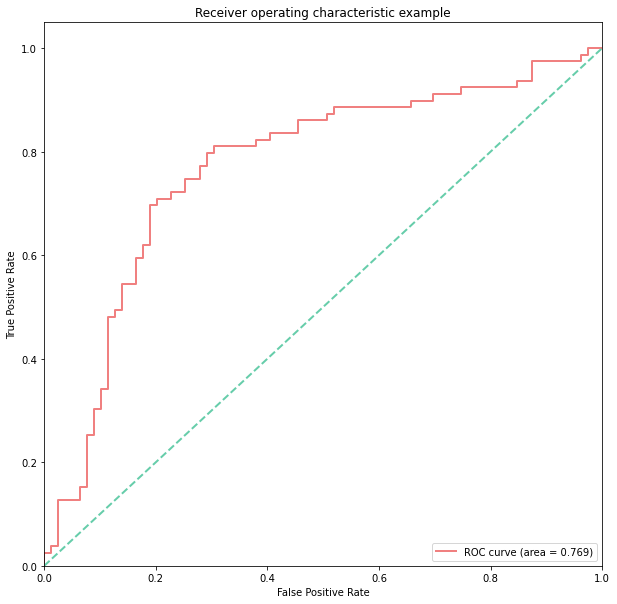

,Accuracy,Recall,Precision
0,0.746835,0.047619,1.0


In [7]:
svm_AB_RD_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 43)
svm_AB_RD = create_model(svm_AB_RD_temp)
rf_AB_RD = create_model('rf')
knn_AB_RD = create_model('et')
svm_AB_RD_final = finalize_model(svm_AB_RD)
rf_AB_RD_final = finalize_model(rf_AB_RD)
knn_AB_RD_final = finalize_model(knn_AB_RD)
blend_AB_RD = blend_models(estimator_list = [svm_AB_RD_final,rf_AB_RD_final,
                                             knn_AB_RD_final],method = 'soft')
method_AB_RD = getattr(blend_AB_RD,"predict_proba")
prob_C_RD = method_AB_RD(data_C_RD[get_config('X_train').columns])
ROC_C_RD = acu_curve(data_C_RD['Group'],prob_C_RD,["NonRD", "Rapid_decliner"],sites = site_AB)
stat_table(data_C_RD['Group'],predict_model(blend_AB_RD,data = data_C_RD)['Label'],pos_label = 'Rapid_decliner')

### SD vs NonSD

In [8]:
data_AB_SD = data_AB.replace(["Rapid_decliner","Sustainer"],"NonSD")
data_C_SD = data_C_fit.replace(["Rapid_decliner","Sustainer"],"NonSD")
AB_SD = setup(data_AB_SD,target = "Group", session_id = 44,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6750,0.6479,0.7000,0.6400,0.6529,0.3544,0.3609,0.0150
ada,Ada Boost Classifier,0.6357,0.7083,0.6750,0.6150,0.6374,0.2766,0.2742,0.0890
lr,Logistic Regression,0.6214,0.6542,0.5917,0.6883,0.6086,0.2515,0.2544,0.0440
knn,K Neighbors Classifier,0.6071,0.5979,0.5250,0.6583,0.5719,0.2204,0.2286,0.0210
et,Extra Trees Classifier,0.6071,0.5958,0.5917,0.5500,0.5671,0.2197,0.2029,0.1530
lightgbm,Light Gradient Boosting Machine,0.5911,0.6708,0.6250,0.5967,0.5975,0.1871,0.1961,0.0340
rf,Random Forest Classifier,0.5804,0.6115,0.5333,0.5617,0.5407,0.1579,0.1555,0.1820
xgboost,Extreme Gradient Boosting,0.5750,0.6625,0.5083,0.5150,0.5026,0.1536,0.1314,0.1330
nb,Naive Bayes,0.5357,0.5688,0.4083,0.4917,0.4219,0.0584,0.0480,0.0110
qda,Quadratic Discriminant Analysis,0.5339,0.5500,0.5500,0.5717,0.5193,0.0988,0.1088,0.0140


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.5625,0.7500,0.6000,0.6667,0.2500,0.2582
1,0.8571,0.6667,0.6667,1.0000,0.8000,0.6957,0.7303
2,0.2857,0.4167,0.3333,0.2500,0.2857,-0.4000,-0.4167
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.5714,0.5833,0.3333,0.5000,0.4000,0.0870,0.0913
5,0.5714,0.8333,1.0000,0.5000,0.6667,0.2222,0.3536
6,0.7143,0.8333,1.0000,0.6667,0.8000,0.3636,0.4714
7,0.5714,0.5833,0.5000,0.6667,0.5714,0.1600,0.1667
8,0.8571,1.0000,1.0000,0.8000,0.8889,0.6957,0.7303
9,0.4286,0.4167,0.2500,0.5000,0.3333,-0.0769,-0.0913


<Figure size 432x288 with 0 Axes>

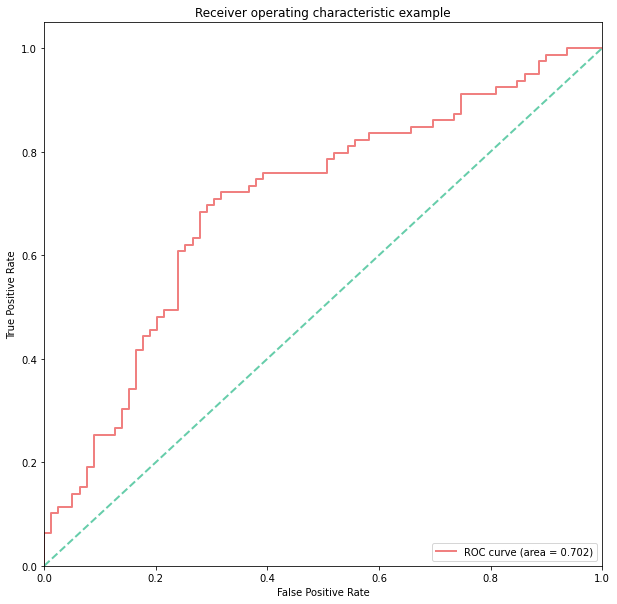

,Accuracy,Recall,Precision
0,0.696203,0.540541,0.740741


In [9]:
et_AB_SD = create_model('et')
et_AB_SD_final = finalize_model(et_AB_SD)
lda_AB_SD = create_model('lda')
lr_AB_SD = create_model('lr')
lda_AB_SD_final = finalize_model(lda_AB_SD)
lr_AB_SD_final = finalize_model(lr_AB_SD)
blend_AB_SD = blend_models(estimator_list = [et_AB_SD_final,lda_AB_SD_final,lr_AB_SD_final],method = 'soft')
method_AB_SD = getattr(blend_AB_SD,"predict_proba")
prob_C_SD = method_AB_SD(data_C_SD[get_config('X_train').columns])
ROC_C_SD = acu_curve(data_C_SD['Group'],prob_C_SD,["NonSD", "Slow_decliner"],sites = site_AB)
stat_table(data_C_SD['Group'],predict_model(blend_AB_SD,data = data_C_SD)['Label'],pos_label = 'Slow_decliner')

### ST vs NonST

In [10]:
data_AB_ST = data_AB.replace(["Rapid_decliner","Slow_decliner"],"NonST")
data_C_ST = data_C_fit.replace(["Rapid_decliner","Slow_decliner"],"NonST")
AB_ST = setup(data_AB_ST,target = "Group", session_id = 45,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.7054,0.0000,0.1000,0.1333,0.1067,0.0675,0.0737,0.0090
gbc,Gradient Boosting Classifier,0.6482,0.5233,0.0833,0.0750,0.0733,-0.0405,-0.0459,0.1560
rf,Random Forest Classifier,0.6339,0.4500,0.0000,0.0000,0.0000,-0.1106,-0.1175,0.1650
lr,Logistic Regression,0.6304,0.5433,0.2167,0.3500,0.2633,0.0398,0.0472,0.0340
et,Extra Trees Classifier,0.6071,0.4900,0.0500,0.0333,0.0400,-0.1250,-0.1376,0.1440
lda,Linear Discriminant Analysis,0.6018,0.4967,0.2167,0.3000,0.2467,-0.0125,-0.0131,0.0130
xgboost,Extreme Gradient Boosting,0.5929,0.3100,0.0500,0.0333,0.0400,-0.1485,-0.1634,0.1260
lightgbm,Light Gradient Boosting Machine,0.5929,0.2300,0.1000,0.1000,0.1000,-0.1137,-0.1267,0.0380
ada,Ada Boost Classifier,0.5661,0.4300,0.2500,0.2583,0.2400,-0.0501,-0.0518,0.0950
dt,Decision Tree Classifier,0.5482,0.4417,0.1833,0.1583,0.1633,-0.1288,-0.1384,0.0120


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=45, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7500,0.7333,0.3333,1.0000,0.5000,0.3846,0.4880
1,0.5714,0.4000,0.0000,0.0000,0.0000,-0.2353,-0.2582
2,0.7143,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8571,1.0000,0.5000,1.0000,0.6667,0.5882,0.6455
4,0.2857,0.2000,0.0000,0.0000,0.0000,-0.5217,-0.5477
5,0.8571,0.6000,0.5000,1.0000,0.6667,0.5882,0.6455
6,0.5714,0.3000,0.0000,0.0000,0.0000,-0.2353,-0.2582
7,0.5714,0.4000,0.0000,0.0000,0.0000,-0.2353,-0.2582
8,0.7143,0.7000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.5714,0.2000,0.0000,0.0000,0.0000,-0.2353,-0.2582


<Figure size 432x288 with 0 Axes>

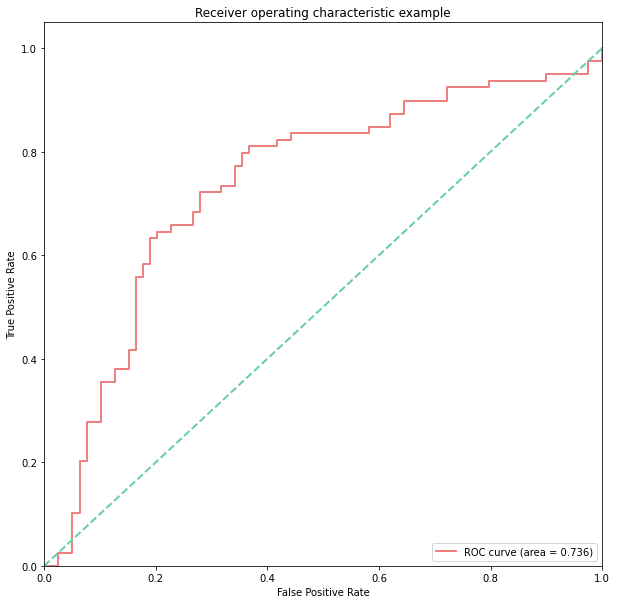

,Accuracy,Recall,Precision
0,0.721519,0.047619,0.333333


In [11]:
svm_AB_ST_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 45)
svm_AB_ST = create_model(svm_AB_ST_temp)
svm_AB_ST_final = finalize_model(svm_AB_ST)
lr_AB_ST = create_model('lr')
nb_AB_ST = create_model('nb')
tuned_nb_AB_ST = tune_model(nb_AB_ST)
lr_AB_ST_final = finalize_model(lr_AB_ST)
nb_AB_ST_final = finalize_model(tuned_nb_AB_ST)
blend_AB_ST = blend_models(estimator_list = [lr_AB_ST_final,nb_AB_ST_final,svm_AB_ST_final],method = 'soft')
method_AB_ST = getattr(blend_AB_ST,"predict_proba")
prob_C_ST = method_AB_ST(data_C_ST[get_config('X_train').columns])
ROC_C_ST = acu_curve(data_C_ST['Group'],prob_C_ST,["NonST", "Sustainer"],sites = site_AB)
stat_table(data_C_ST['Group'],predict_model(blend_AB_ST,data = data_C_ST)['Label'],pos_label = 'Sustainer')

## Site A & C for fitting, B for prediction

In [12]:
from pycaret.regression import *
data_AC = pd.concat([data_A,data_C])
setup(data_AC, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7, train_size = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group','Site'],silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,155.9772,205202.3823,327.8772,-0.1003,1.1366,0.5797,0.0660
br,Bayesian Ridge,175.4814,210874.9255,345.1265,-0.3725,0.9218,0.9639,0.0180
et,Extra Trees Regressor,187.6606,181313.0994,342.7488,-1.3559,1.0641,1.2290,0.1550
par,Passive Aggressive Regressor,256.9425,242500.3117,405.5113,-2.3704,1.3203,2.2159,0.0100
en,Elastic Net,265.1454,210969.7566,392.8344,-2.4088,1.3868,2.4930,0.0110
xgboost,Extreme Gradient Boosting,208.2218,294218.6725,425.8904,-3.0458,1.1349,1.2064,0.2700
lightgbm,Light Gradient Boosting Machine,258.3036,242588.5945,415.9578,-3.2837,1.2491,2.2366,0.0320
knn,K Neighbors Regressor,228.6297,249566.9559,415.3622,-3.3952,1.3822,1.6722,0.0140
omp,Orthogonal Matching Pursuit,301.6465,227230.6354,423.7141,-3.7446,1.4339,3.0610,0.0100
llar,Lasso Least Angle Regression,355.1400,265005.6211,480.2319,-6.0410,1.4512,3.9962,0.0140


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [13]:
reg_ada_AC = create_model('ada')
ada_AC_final = finalize_model(reg_ada_AC)
ada_AC = tune_model(ada_AC_final)
pred_B = predict_model(ada_AC,data = data_B)['Label']
pred_AC = predict_model(ada_AC,data = data_AC)['Label']
data_AC['FEV1_rate'] = pred_AC
data_B_fit = data_B
data_B_fit['FEV1_rate'] = pred_B

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,110.1059,27967.3232,167.2343,0.1115,1.2213,0.5655
1,46.1214,9375.4407,96.8269,0.2358,1.3238,0.4304
2,321.0883,849339.9371,921.5964,-0.1087,1.4301,0.4006
3,421.8840,889559.8654,943.1648,-0.0405,1.6984,0.6281
4,123.2177,77806.1823,278.9376,-0.1017,1.1780,0.6045
5,163.8662,80904.2150,284.4367,-0.0866,1.1910,0.5870
6,129.5861,52295.1734,228.6814,0.0544,1.7573,0.4936
7,135.5926,43215.4485,207.8833,-0.0922,1.5662,0.6123
8,46.1078,7360.3300,85.7924,0.1494,0.5801,0.5558
9,42.1320,4780.2496,69.1393,-0.4714,0.6910,0.5349


### RD vs NonRD

In [14]:
from pycaret.classification import *
data_AC_RD = data_AC.replace(["Slow_decliner","Sustainer"],"NonRD")
data_B_RD = data_B_fit.replace(["Slow_decliner","Sustainer"],"NonRD")
AC_RD = setup(data_AC_RD,target = "Group", session_id = 43,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7864,0.6354,0.1333,0.3000,0.1833,0.1485,0.1649,0.1400
rf,Random Forest Classifier,0.7564,0.4673,0.0500,0.1000,0.0667,0.0304,0.0306,0.1790
xgboost,Extreme Gradient Boosting,0.7255,0.6360,0.1000,0.2000,0.1300,0.0143,0.0218,0.1500
gbc,Gradient Boosting Classifier,0.7164,0.5857,0.2333,0.2250,0.2233,0.0938,0.0867,0.1920
lightgbm,Light Gradient Boosting Machine,0.7064,0.5262,0.0667,0.1000,0.0800,-0.0449,-0.0536,0.0490
svm,SVM - Linear Kernel,0.6964,0.0000,0.2500,0.1500,0.1800,0.0462,0.0568,0.0100
knn,K Neighbors Classifier,0.6955,0.4914,0.1167,0.1167,0.1167,-0.0153,-0.0190,0.0190
lr,Logistic Regression,0.6891,0.6324,0.3667,0.3117,0.3283,0.1471,0.1404,0.0550
ada,Ada Boost Classifier,0.6782,0.5339,0.2500,0.2200,0.2286,0.0571,0.0472,0.1110
dt,Decision Tree Classifier,0.6291,0.4869,0.2167,0.1617,0.1805,-0.0418,-0.0488,0.0180


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=43, verbose=0,
                     warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6364,0.6250,0.0000,0.0000,0.0000,-0.1579,-0.1936
1,0.7273,0.4167,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6000,0.5625,0.0000,0.0000,0.0000,-0.2500,-0.2500
3,0.7000,0.5000,0.0000,0.0000,0.0000,-0.1538,-0.1667
4,0.8000,0.3750,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8000,0.8750,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9000,1.0000,0.5000,1.0000,0.6667,0.6154,0.6667
7,0.8000,0.5625,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6000,0.4762,0.0000,0.0000,0.0000,-0.1765,-0.2182
9,0.7000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

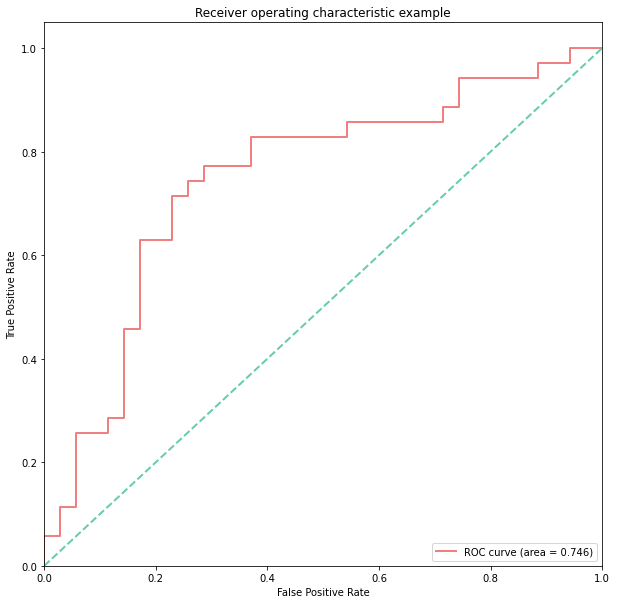

,Accuracy,Recall,Precision
0,0.742857,0.4,0.571429


In [15]:
#svm_AC_RD_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 43)
svm_AC_RD = create_model('gbc')
knn_AC_RD = create_model('knn')
nb_AC_RD = create_model('nb')
svm_AC_RD_final = finalize_model(svm_AC_RD)
knn_AC_RD_final = finalize_model(knn_AC_RD)
nb_AC_RD_final = finalize_model(nb_AC_RD)
blend_AC_RD = blend_models(estimator_list = [svm_AC_RD_final,knn_AC_RD_final,tune_model(nb_AC_RD_final)],method = 'soft')
method_AC_RD = getattr(blend_AC_RD,"predict_proba")
prob_B_RD = method_AC_RD(data_B_RD[get_config('X_train').columns])
ROC_B_RD = acu_curve(data_B_RD['Group'],prob_B_RD,["NonRD", "Rapid_decliner"],sites = site_AC)
stat_table(data_B_RD['Group'],predict_model(blend_AC_RD,data = data_B_RD)['Label'],pos_label = 'Rapid_decliner')

### SD vs NonSD

In [16]:
data_AC_SD = data_AC.replace(["Rapid_decliner","Sustainer"],"NonSD")
data_B_SD = data_B_fit.replace(["Rapid_decliner","Sustainer"],"NonSD")
AC_SD = setup(data_AC_SD,target = "Group", session_id = 44,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6364,0.6890,0.6650,0.5988,0.6233,0.2672,0.2766,0.0190
lightgbm,Light Gradient Boosting Machine,0.6264,0.6597,0.5050,0.6350,0.5497,0.2334,0.2461,0.0470
nb,Naive Bayes,0.6191,0.6050,0.6000,0.6002,0.5811,0.2296,0.2498,0.0110
gbc,Gradient Boosting Classifier,0.5818,0.6303,0.4750,0.6367,0.4942,0.1559,0.1889,0.1960
et,Extra Trees Classifier,0.5800,0.5876,0.4450,0.5495,0.4575,0.1433,0.1507,0.1510
xgboost,Extreme Gradient Boosting,0.5627,0.5902,0.4850,0.5221,0.4769,0.1106,0.1152,0.2040
rf,Random Forest Classifier,0.5609,0.6137,0.4350,0.4844,0.4074,0.1126,0.1170,0.1690
qda,Quadratic Discriminant Analysis,0.5400,0.5317,0.4400,0.4679,0.4420,0.0604,0.0554,0.0120
dt,Decision Tree Classifier,0.5227,0.5208,0.4350,0.4683,0.4403,0.0364,0.0387,0.0150
ada,Ada Boost Classifier,0.5182,0.5453,0.4400,0.5124,0.4484,0.0252,0.0340,0.0870


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7273,0.8000,0.6000,0.7500,0.6667,0.4407,0.4485
1,0.6364,0.6000,0.6000,0.6000,0.6000,0.2667,0.2667
2,0.7000,0.7500,0.5000,0.6667,0.5714,0.3478,0.3563
3,0.8000,0.8750,1.0000,0.6667,0.8000,0.6154,0.6667
4,0.7000,0.7917,0.5000,0.6667,0.5714,0.3478,0.3563
5,0.6000,0.6000,0.6000,0.6000,0.6000,0.2000,0.2000
6,0.7000,0.7200,0.6000,0.7500,0.6667,0.4000,0.4082
7,0.4000,0.4400,0.4000,0.4000,0.4000,-0.2000,-0.2000
8,0.5000,0.6800,0.2000,0.5000,0.2857,0.0000,0.0000
9,0.6000,0.5600,0.6000,0.6000,0.6000,0.2000,0.2000


<Figure size 432x288 with 0 Axes>

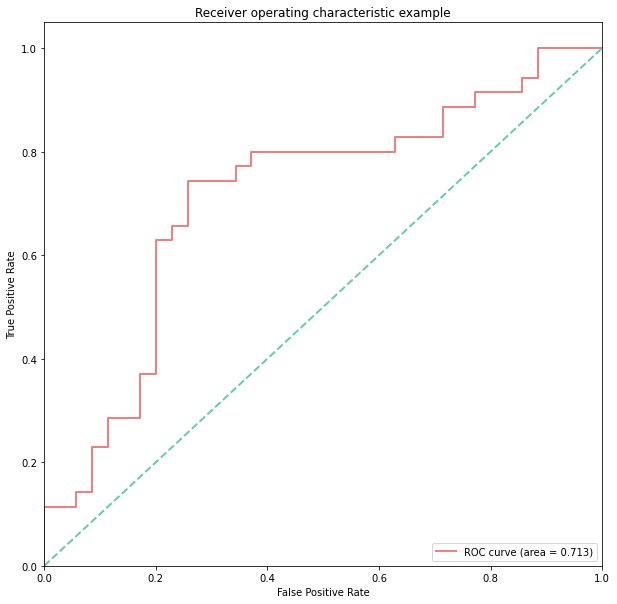

,Accuracy,Recall,Precision
0,0.742857,0.722222,0.764706


In [17]:
qda_AC_SD = create_model('knn')
lda_AC_SD = create_model('lightgbm')
ada_AC_SD = create_model('gbc')
ada_AC_SD_final = finalize_model(ada_AC_SD)
lda_AC_SD_final = finalize_model(lda_AC_SD)
qda_AC_SD_final = finalize_model(qda_AC_SD)
blend_AC_SD = blend_models(estimator_list = [qda_AC_SD_final,tune_model(lda_AC_SD_final),
                                             tune_model(ada_AC_SD_final)],method = 'soft')
method_AC_SD = getattr(blend_AC_SD,"predict_proba")
prob_B_SD = method_AC_SD(data_B_SD[get_config('X_train').columns])
ROC_B_SD = acu_curve(data_B_SD['Group'],prob_B_SD,["NonSD", "Slow_decliner"],sites = site_AC)
stat_table(data_B_SD['Group'],predict_model(blend_AC_SD,data = data_B_SD)['Label'],pos_label = 'Slow_decliner')

### ST vs NonST

In [18]:
data_AC_ST = data_AC.replace(["Rapid_decliner","Slow_decliner"],"NonST")
data_B_ST = data_B_fit.replace(["Rapid_decliner","Slow_decliner"],"NonST")
AC_ST = setup(data_AC_ST,target = "Group", session_id = 45,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7545,0.5872,0.2000,0.2667,0.2100,0.1271,0.1354,0.1630
dt,Decision Tree Classifier,0.7527,0.6179,0.3500,0.4917,0.3657,0.2407,0.2688,0.0150
rf,Random Forest Classifier,0.7445,0.5918,0.1333,0.2000,0.1500,0.0855,0.0939,0.2090
knn,K Neighbors Classifier,0.7364,0.4927,0.0833,0.2000,0.1167,0.0408,0.0482,0.0190
gbc,Gradient Boosting Classifier,0.7327,0.6616,0.2000,0.3500,0.2467,0.1179,0.1231,0.1870
ada,Ada Boost Classifier,0.7145,0.6116,0.3167,0.3500,0.3238,0.1547,0.1570,0.0890
et,Extra Trees Classifier,0.7055,0.6704,0.1500,0.2000,0.1667,0.0491,0.0446,0.1470
lightgbm,Light Gradient Boosting Machine,0.7055,0.5714,0.1333,0.1000,0.1067,-0.0059,-0.0135,0.0700
lr,Logistic Regression,0.6955,0.5423,0.1667,0.2833,0.1900,0.0364,0.0463,0.0730
lda,Linear Discriminant Analysis,0.6764,0.5061,0.4333,0.3362,0.3555,0.1544,0.1751,0.0130


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=45, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8182,0.8750,0.3333,1.0000,0.5000,0.4211,0.5164
1,0.9091,1.0000,1.0000,0.7500,0.8571,0.7925,0.8101
2,0.8000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7000,0.6250,0.5000,0.3333,0.4000,0.2105,0.2182
4,0.7000,0.6875,0.5000,0.3333,0.4000,0.2105,0.2182
5,0.6000,0.5625,0.0000,0.0000,0.0000,-0.2500,-0.2500
6,0.8000,0.8750,0.5000,0.5000,0.5000,0.3750,0.3750
7,0.8000,0.4762,0.3333,1.0000,0.5000,0.4118,0.5092
8,0.6000,0.0952,0.0000,0.0000,0.0000,-0.1765,-0.2182
9,0.8000,0.7143,0.3333,1.0000,0.5000,0.4118,0.5092


<Figure size 432x288 with 0 Axes>

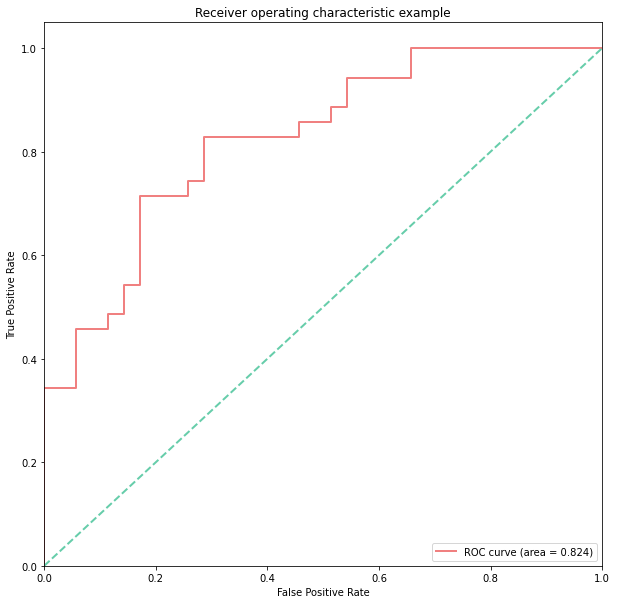

,Accuracy,Recall,Precision
0,0.742857,0.142857,0.25


In [19]:
rf_AC_ST = create_model('rf')
dt_AC_ST = create_model('dt')
ada_AC_ST = create_model('ada')
ada_AC_ST_final = finalize_model(ada_AC_ST)
dt_AC_ST_final = finalize_model(dt_AC_ST)
rf_AC_ST_final = finalize_model(rf_AC_ST)
blend_AC_ST = blend_models(estimator_list = [rf_AC_ST_final,dt_AC_ST_final,ada_AC_ST_final],method = 'soft')
method_AC_ST = getattr(blend_AC_ST,"predict_proba")
prob_B_ST = method_AC_ST(data_B_ST[get_config('X_train').columns])
ROC_B_ST = acu_curve(data_B_ST['Group'],prob_B_ST,["NonST", "Sustainer"],sites = site_AC)
stat_table(data_B_ST['Group'],predict_model(blend_AC_ST,data = data_B_ST)['Label'],pos_label = 'Sustainer')

## Site B & C for fitting, A for prediction

In [20]:
from pycaret.regression import *
data_BC = pd.concat([data_B,data_C])
setup(data_BC, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7, train_size = 0.7,
      transformation = True,session_id = 42,ignore_features = ['Group','Site'],silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,52.4467,104787.6852,123.7783,0.2954,0.3709,0.2537,0.0550
par,Passive Aggressive Regressor,81.0590,112350.5078,156.8416,-3.1017,0.9533,0.6140,0.0110
huber,Huber Regressor,84.5818,112269.3245,156.6828,-4.2072,0.9986,0.6707,0.0210
br,Bayesian Ridge,87.3339,110042.0991,154.5449,-6.2418,0.7159,0.8203,0.0110
lightgbm,Light Gradient Boosting Machine,118.1832,116927.9746,198.7849,-16.4915,1.0185,1.2457,0.0300
knn,K Neighbors Regressor,89.7751,127309.2045,197.1797,-22.0021,0.6716,0.7910,0.0130
et,Extra Trees Regressor,110.1005,119669.1610,204.9502,-23.2704,0.8684,1.1509,0.1420
en,Elastic Net,167.3409,135507.7739,258.0662,-42.0808,1.1124,1.9377,0.0100
llar,Lasso Least Angle Regression,233.1574,182711.6866,349.7557,-103.5318,1.3368,2.8565,0.0150
omp,Orthogonal Matching Pursuit,212.7933,162272.7368,315.3383,-113.3347,1.3410,2.5847,0.0090


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [21]:
reg_ada_BC = create_model('ada')
ada_BC_final = finalize_model(reg_ada_BC)
ada_BC = tune_model(ada_BC_final)
pred_A = predict_model(ada_BC,data = data_A)['Label']
pred_BC = predict_model(ada_BC,data = data_BC)['Label']
data_BC['FEV1_rate'] = pred_BC
data_A_fit = data_A
data_A_fit['FEV1_rate'] = pred_A

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.9799,680.7024,26.0903,0.2686,0.2636,0.1895
1,14.1120,348.4531,18.6669,0.8010,0.2309,0.1526
2,31.4610,2004.8836,44.7759,-0.1243,0.4879,0.3648
3,16.3794,431.3905,20.7699,0.6612,0.2157,0.1914
4,6.5392,75.9284,8.7137,0.1783,0.1335,0.1065
5,367.5583,1038965.4725,1019.2966,-0.1188,1.1491,0.1895
6,14.1035,578.7485,24.0572,0.7969,0.1635,0.1356
7,12.9708,285.6423,16.9010,0.7307,0.2616,0.2319
8,10.7598,269.1148,16.4047,0.1903,0.1550,0.1438
9,13.0645,255.5929,15.9873,0.8733,0.1814,0.1436


### RD vs NonRD

In [22]:
from pycaret.classification import *
data_BC_RD = data_BC.replace(["Slow_decliner","Sustainer"],"NonRD")
data_A_RD = data_A_fit.replace(["Slow_decliner","Sustainer"],"NonRD")
BC_RD = setup(data_BC_RD,target = "Group", session_id = 43,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7464,0.4900,0.1833,0.3500,0.2400,0.1543,0.1677,0.1460
rf,Random Forest Classifier,0.7339,0.5158,0.1000,0.2000,0.1333,0.0800,0.0873,0.1620
knn,K Neighbors Classifier,0.7089,0.5400,0.1500,0.2000,0.1667,0.0636,0.0592,0.0180
xgboost,Extreme Gradient Boosting,0.6839,0.4833,0.1333,0.3000,0.1833,0.0551,0.0668,0.1150
lightgbm,Light Gradient Boosting Machine,0.6714,0.3667,0.1500,0.1250,0.1333,0.0133,0.0115,0.0360
dt,Decision Tree Classifier,0.6464,0.5617,0.3833,0.3417,0.3419,0.1136,0.1272,0.0130
gbc,Gradient Boosting Classifier,0.6214,0.4017,0.1333,0.1667,0.1400,-0.0686,-0.0698,0.1300
ada,Ada Boost Classifier,0.6071,0.4067,0.1833,0.1500,0.1633,-0.0645,-0.0692,0.0750
svm,SVM - Linear Kernel,0.5964,0.0000,0.2500,0.1000,0.1300,-0.0095,-0.0114,0.0090
lr,Logistic Regression,0.5929,0.4050,0.1500,0.1833,0.1567,-0.0952,-0.0928,0.0390


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=43, verbose=0,
                     warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.8333,0.0000,0.0000,0.0000,-0.2000,-0.2182
1,0.6250,0.6667,0.0000,0.0000,0.0000,-0.2000,-0.2182
2,0.5000,0.1667,0.0000,0.0000,0.0000,-0.3333,-0.3333
3,0.7500,0.8333,0.5000,0.5000,0.5000,0.3333,0.3333
4,0.6250,0.3333,0.0000,0.0000,0.0000,-0.2000,-0.2182
5,0.7500,0.5833,0.5000,0.5000,0.5000,0.3333,0.3333
6,0.5000,0.6667,0.0000,0.0000,0.0000,-0.3333,-0.3333
7,0.7500,0.5833,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.5000,0.6667,0.3333,0.3333,0.3333,-0.0667,-0.0667
9,0.7143,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

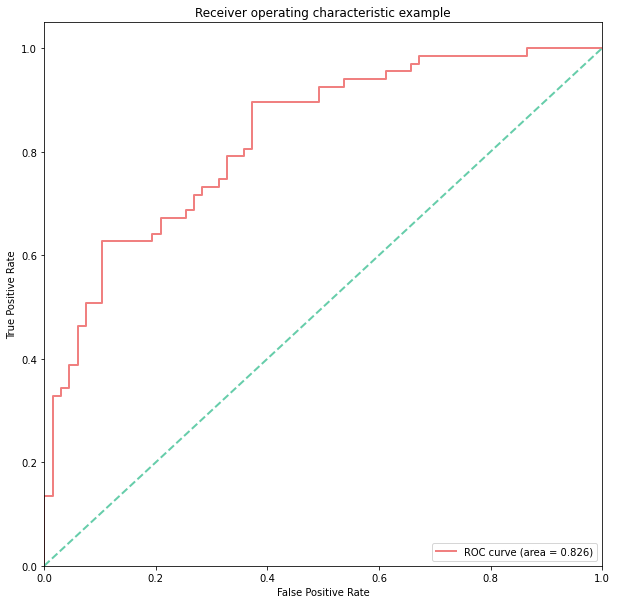

,Accuracy,Recall,Precision
0,0.716418,0.266667,0.333333


In [23]:
lda_BC_RD = create_model('lda')
lda_BC_RD_final = finalize_model(lda_BC_RD)
et_BC_RD = create_model('et')
et_BC_RD_final = finalize_model(et_BC_RD)
dt_BC_RD = create_model('dt')
dt_BC_RD_final = finalize_model(dt_BC_RD)
blend_BC_RD = blend_models(estimator_list = [lda_BC_RD_final,et_BC_RD_final,tune_model(dt_BC_RD_final)],method = 'soft')

method_BC_RD = getattr(blend_BC_RD,"predict_proba")
prob_A_RD = method_BC_RD(data_A_RD[get_config('X_train').columns])
ROC_A_RD = acu_curve(data_A_RD['Group'],prob_A_RD,["NonRD", "Rapid_decliner"],sites = site_BC)
stat_table(data_A_RD['Group'],predict_model(blend_BC_RD,data = data_A_RD)['Label'],pos_label = 'Rapid_decliner')

### SD vs NonSD

In [24]:
data_BC_SD = data_BC.replace(["Rapid_decliner","Sustainer"],"NonSD")
data_A_SD = data_A_fit.replace(["Rapid_decliner","Sustainer"],"NonSD")
BC_SD = setup(data_BC_SD,target = "Group", session_id = 44,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6071,0.6073,0.3333,0.5300,0.3879,0.2087,0.2039,0.0180
lr,Logistic Regression,0.5964,0.6208,0.5667,0.6262,0.5579,0.1917,0.1994,0.0410
et,Extra Trees Classifier,0.5679,0.5167,0.5583,0.4555,0.4952,0.1333,0.1307,0.1540
lda,Linear Discriminant Analysis,0.5554,0.5042,0.4667,0.5483,0.4826,0.1173,0.1124,0.0160
ridge,Ridge Classifier,0.5464,0.0000,0.5167,0.4945,0.4907,0.0917,0.0797,0.0090
qda,Quadratic Discriminant Analysis,0.5446,0.5417,0.4333,0.5400,0.4702,0.0837,0.0833,0.0130
lightgbm,Light Gradient Boosting Machine,0.5304,0.4896,0.4833,0.5571,0.4989,0.0583,0.0821,0.0540
dt,Decision Tree Classifier,0.5196,0.5208,0.4917,0.4767,0.4767,0.0410,0.0305,0.0110
xgboost,Extreme Gradient Boosting,0.5196,0.4833,0.4333,0.5095,0.4485,0.0337,0.0171,0.1430
svm,SVM - Linear Kernel,0.5054,0.0000,0.3750,0.3095,0.2905,0.0250,0.0258,0.0090


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6250,0.8125,0.5000,0.6667,0.5714,0.2500,0.2582
1,0.5000,0.5625,0.2500,0.5000,0.3333,0.0000,0.0000
2,0.7500,0.8750,1.0000,0.6667,0.8000,0.5000,0.5774
3,0.3750,0.5625,0.2500,0.3333,0.2857,-0.2500,-0.2582
4,0.8750,0.8125,0.7500,1.0000,0.8571,0.7500,0.7746
5,0.3750,0.3750,0.2500,0.3333,0.2857,-0.2500,-0.2582
6,0.5000,0.5625,0.2500,0.5000,0.3333,0.0000,0.0000
7,0.5000,0.8750,1.0000,0.5000,0.6667,0.0000,0.0000
8,0.5000,0.3750,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.5714,0.4167,0.3333,0.5000,0.4000,0.0870,0.0913


<Figure size 432x288 with 0 Axes>

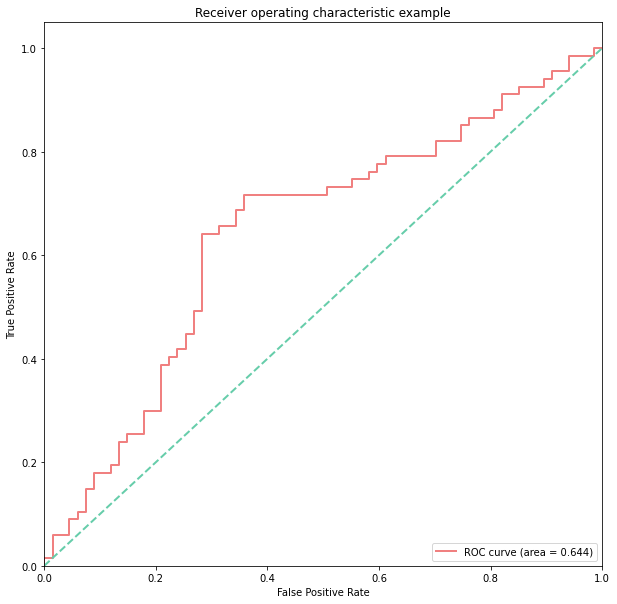

,Accuracy,Recall,Precision
0,0.656716,0.413793,0.666667


In [25]:
et_BC_SD = create_model('et')
et_BC_SD_final = finalize_model(et_BC_SD)
lr_BC_SD = create_model('lr')
lr_BC_SD_final = finalize_model(lr_BC_SD)
knn_BC_SD = create_model('knn')
knn_BC_SD_final = finalize_model(knn_BC_SD)
blend_BC_SD = blend_models(estimator_list = [et_BC_SD_final,lr_BC_SD_final,knn_BC_SD_final],method = 'soft')

method_BC_SD = getattr(blend_BC_SD,"predict_proba")
prob_A_SD = method_BC_SD(data_A_SD[get_config('X_train').columns])
ROC_A_SD = acu_curve(data_A_SD['Group'],prob_A_SD,["NonSD", "Slow_decliner"],sites = site_BC)
stat_table(data_A_SD['Group'],predict_model(blend_BC_SD,data = data_A_SD)['Label'],pos_label = 'Slow_decliner')

### ST vs NonST

In [26]:
data_BC_ST = data_BC.replace(["Rapid_decliner","Slow_decliner"],"NonST")
data_A_ST = data_A_fit.replace(["Rapid_decliner","Slow_decliner"],"NonST")
BC_ST = setup(data_BC_ST,target = "Group", session_id = 45,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8107,0.6214,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
et,Extra Trees Classifier,0.7982,0.3833,0.0000,0.0000,0.0000,-0.0143,-0.0143,0.1460
rf,Random Forest Classifier,0.7857,0.4202,0.0000,0.0000,0.0000,-0.0343,-0.0361,0.1690
gbc,Gradient Boosting Classifier,0.7607,0.3125,0.1500,0.1333,0.1167,0.0385,0.0488,0.1230
xgboost,Extreme Gradient Boosting,0.7482,0.2988,0.0000,0.0000,0.0000,-0.0800,-0.0873,0.1190
lightgbm,Light Gradient Boosting Machine,0.7357,0.2238,0.0000,0.0000,0.0000,-0.1029,-0.1083,0.0350
lr,Logistic Regression,0.7232,0.2440,0.0000,0.0000,0.0000,-0.0974,-0.1090,0.0450
dt,Decision Tree Classifier,0.7089,0.5393,0.2500,0.1000,0.1400,0.0069,0.0264,0.0130
lda,Linear Discriminant Analysis,0.6839,0.4131,0.1500,0.1333,0.1400,-0.0329,-0.0377,0.0130
ada,Ada Boost Classifier,0.6607,0.3119,0.0000,0.0000,0.0000,-0.1752,-0.1825,0.0770


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8750,0.8571,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8750,0.8571,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8750,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8750,0.5714,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7500,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7500,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7500,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7500,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7500,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.8571,0.1667,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

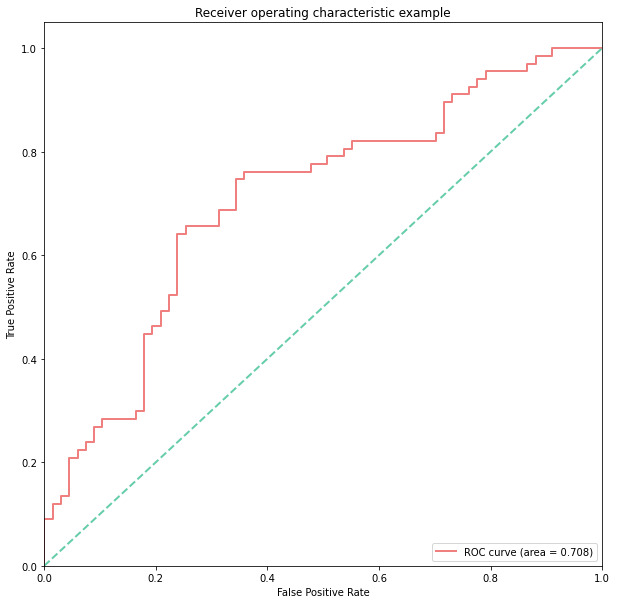

,Accuracy,Recall,Precision
0,0.686567,0.217391,0.625


In [27]:
et_BC_ST = create_model('et')
et_BC_ST_final = finalize_model(et_BC_ST)
gbc_BC_ST = create_model('gbc')
gbc_BC_ST_final = finalize_model(gbc_BC_ST)
knn_BC_ST = create_model('knn')
knn_BC_ST_final = finalize_model(knn_BC_ST)
blend_BC_ST = blend_models(estimator_list = [et_BC_ST_final,gbc_BC_ST_final,knn_BC_ST_final],method = 'soft')

method_BC_ST = getattr(blend_BC_ST,"predict_proba")
prob_A_ST = method_BC_ST(data_A_ST[get_config('X_train').columns])
ROC_A_ST = acu_curve(data_A_ST['Group'],prob_A_ST,["NonST", "Sustainer"],sites = site_BC)
stat_table(data_A_ST['Group'],predict_model(blend_BC_ST,data = data_A_ST)['Label'],pos_label = 'Sustainer')